SWIR-ViT Wildfire Detection

In [1]:
# Cell 1: Check GPU
print("🔍 Checking GPU...")
import torch
!nvidia-smi
print(f"\nPyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


🔍 Checking GPU...
Tue Oct 21 08:05:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------

In [2]:
# ===================================================================
# Cell 2: Install Dependencies
print("\n" + "="*60)
print("📦 INSTALLING DEPENDENCIES")
print("="*60)
!pip install -q timm transformers rasterio pillow pyyaml scikit-learn tqdm
print("✅ Dependencies installed!")



📦 INSTALLING DEPENDENCIES
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 93.7 MB/s eta 0:00:00
✅ Dependencies installed!


In [4]:
print("\n" + "="*60)
print("📁 MOUNTING GOOGLE DRIVE")
print("="*60)

from google.colab import drive
drive.mount('/content/drive')

print("✅ Google Drive mounted!")
print("\nYour Drive contents:")
!ls /content/drive/MyDrive/



📁 MOUNTING GOOGLE DRIVE
Mounted at /content/drive
✅ Google Drive mounted!

Your Drive contents:
'Autophagy: Mechanisms, Roles, Therapeutics.'$'\n''.gdoc'
 balance_bovine_dataset
 Breeddataset
 Cattleclassifier
'Colab Notebooks'
 Data
 DATASET
 Doc.pdf
'E23CSEU1203(YASH PRATAP SINGH).pdf'
 emily-underworld-Ko3EMBFggok-unsplash.pdf
'Fire neitherfirenorsmoke'
'Hackathon Invitation.gform'
 Newspaper_detection
 NPL_PROJECTS
 Os.pdf
'Pickle Website Suggestions.gform'
'Pickle Website Suggestions (Responses).gsheet'
'Powerbi excel'
'Skill Nation Excel Shortcuts.pdf'
 Software_Engineers_Resume_Data.xlsx
 SRGAN_Project
'Top Leetcode questions of All Time - most important (1).xlsx'
'Top Leetcode questions of All Time - most important.gsheet'
'Top Leetcode questions of All Time - most important.xlsx'
'Untitled form.gform'
 Waste_dataset
 YOLO


In [8]:
# ===================================================================
# Cell 3: Copy Data from Google Drive
print("\n" + "="*60)
print("📦 COPYING DATA FROM DRIVE")
print("="*60)

# Your exact path from screenshot
data_path = '/content/drive/MyDrive/Fire neitherfirenorsmoke/processed.zip'

# Copy to Colab workspace
!cp "{data_path}" .

print("✅ Data copied!")

# Extract
print("\nExtracting processed.zip...")
!unzip -q processed.zip

print("✅ Extraction complete!")

# Check extracted structure
print("\n📁 Extracted structure:")
!ls -la



📦 COPYING DATA FROM DRIVE
✅ Data copied!

Extracting processed.zip...
✅ Extraction complete!

📁 Extracted structure:
total 354124
drwxr-xr-x 1 root root      4096 Oct 21 08:20 .
drwxr-xr-x 1 root root      4096 Oct 21 08:04 ..
drwxr-xr-x 4 root root      4096 Oct 17 22:29 .config
drwx------ 5 root root      4096 Oct 21 08:16 drive
drwxr-xr-x 3 root root      4096 Oct 21 08:20 __MACOSX
drwxr-xr-x 5 root root      4096 Oct 21 08:05 processed
-rw------- 1 root root 362589331 Oct 21 08:20 processed.zip
drwxr-xr-x 1 root root      4096 Oct 17 22:29 sample_data


In [9]:
print("\n" + "="*60)
print("🔍 VERIFYING DATA")
print("="*60)

import os
import pandas as pd

# Check if processed folder exists
if os.path.exists('processed'):
    print("✅ 'processed' folder found")

    # Count images
    print("\n📊 Image Counts:")
    print("-" * 60)
    for split in ['train', 'val', 'test']:
        split_path = f'processed/{split}'
        if os.path.exists(split_path):
            print(f"\n{split.upper()}:")
            for cls in ['fire', 'neitherFireNorSmoke']:
                cls_path = f'{split_path}/{cls}'
                if os.path.exists(cls_path):
                    files = [f for f in os.listdir(cls_path) if f.endswith('.tif')]
                    print(f"  {cls:20s}: {len(files):5d} images")
                else:
                    print(f"  {cls:20s}: NOT FOUND")
        else:
            print(f"{split}: NOT FOUND")
else:
    print("❌ 'processed' folder not found!")
    print("\nCurrent directory contents:")
    !ls -la

# Check annotations
if os.path.exists('annotations/labels.csv'):
    df = pd.read_csv('annotations/labels.csv')
    print(f"\n✅ Annotations: {len(df)} rows")
    print(f"\nSplit distribution:")
    print(df['split'].value_counts())
elif os.path.exists('processed/annotations/labels.csv'):
    df = pd.read_csv('processed/annotations/labels.csv')
    print(f"\n✅ Annotations found in processed/annotations/")
    print(f"Total rows: {len(df)}")
else:
    print("\n⚠️  Annotations not found - will need to create")



🔍 VERIFYING DATA
✅ 'processed' folder found

📊 Image Counts:
------------------------------------------------------------

TRAIN:
  fire                :  7609 images
  neitherFireNorSmoke :  5056 images

VAL:
  fire                :   200 images
  neitherFireNorSmoke :   133 images

TEST:
  fire                :   201 images
  neitherFireNorSmoke :   133 images

⚠️  Annotations not found - will need to create


In [10]:
# ===================================================================
# Cell 5: Create Annotations CSV
print("\n" + "="*60)
print("📝 CREATING ANNOTATIONS CSV")
print("="*60)

import os
import pandas as pd

# Create annotations from directory structure
annotations = []

for split in ['train', 'val', 'test']:
    for label in ['fire', 'neitherFireNorSmoke']:
        folder_path = f'processed/{split}/{label}'

        if os.path.exists(folder_path):
            images = [f for f in os.listdir(folder_path) if f.endswith('.tif')]

            for img in images:
                annotations.append({
                    'image_name': img,
                    'label': label,
                    'split': split,
                    'augmented': '_aug' in img  # Check if augmented
                })

# Create DataFrame
df = pd.DataFrame(annotations)

# Save to CSV
os.makedirs('annotations', exist_ok=True)
df.to_csv('annotations/labels.csv', index=False)

print(f"✅ Created annotations.csv with {len(df)} rows")

# Show statistics
print("\n📊 Annotation Statistics:")
print(df.groupby(['split', 'label']).size().unstack(fill_value=0))

print(f"\n💾 Saved to: annotations/labels.csv")



📝 CREATING ANNOTATIONS CSV
✅ Created annotations.csv with 13332 rows

📊 Annotation Statistics:
label  fire  neitherFireNorSmoke
split                           
test    201                  133
train  7609                 5056
val     200                  133

💾 Saved to: annotations/labels.csv


In [11]:
print("\n" + "="*60)
print("📦 INSTALLING PACKAGES")
print("="*60)
!pip install -q timm transformers rasterio pillow pyyaml scikit-learn tqdm
print("✅ Installed!")



📦 INSTALLING PACKAGES
✅ Installed!


In [12]:
print("\n" + "="*60)
print("⚙️  CREATING CONFIGS")
print("="*60)

os.makedirs('configs', exist_ok=True)

with open('configs/model_config.yaml', 'w') as f:
    f.write("""model:
  name: "deit_base_patch16_224"
  architecture: "deit"
  input_channels: 1
  image_size: 224
  patch_size: 16
  embed_dim: 768
  depth: 12
  num_heads: 12
  mlp_ratio: 4.0
  num_classes: 2
  drop_rate: 0.1
  attn_drop_rate: 0.1
  pretrained: true
  pretrained_path: "facebook/deit-base-patch16-224"
""")

with open('configs/training_config.yaml', 'w') as f:
    f.write("""training:
  epochs: 50
  batch_size: 64
  num_workers: 2
  seed: 42
  early_stopping:
    patience: 10
    min_delta: 0.001
  optimizer:
    type: "AdamW"
    lr_head: 0.0001
    lr_backbone: 0.00001
    weight_decay: 0.05
    betas: [0.9, 0.999]
  scheduler:
    type: "CosineAnnealingLR"
    T_max: 50
    eta_min: 0.000001
  loss:
    type: "CrossEntropyLoss"
    label_smoothing: 0.1
  gradient_clip: 1.0
  use_amp: true
  log_interval: 10
  save_interval: 5
""")

with open('configs/data_config.yaml', 'w') as f:
    f.write("""data:
  processed_dir: "processed"
  annotations: "annotations/labels.csv"
  classes:
    - fire
    - neitherFireNorSmoke
  normalization:
    method: "zscore"
    mean: 0.5
    std: 0.5
""")

print("✅ Configs created!")



⚙️  CREATING CONFIGS
✅ Configs created!


In [13]:
print("\n" + "="*60)
print("💻 CREATING SOURCE CODE")
print("="*60)

for dir in ['src/data', 'src/models', 'scripts', 'outputs/checkpoints', 'outputs/logs']:
    os.makedirs(dir, exist_ok=True)

# Dataset
with open('src/data/dataset.py', 'w') as f:
    f.write("""import torch
from torch.utils.data import Dataset
from PIL import Image
import rasterio
import numpy as np
from pathlib import Path
import pandas as pd

class SWIRWildfireDataset(Dataset):
    def __init__(self, data_dir, annotations_file, transform=None, mode='train'):
        self.data_dir = Path(data_dir)
        self.mode = mode
        self.annotations = pd.read_csv(annotations_file)
        self.annotations = self.annotations[self.annotations['split'] == mode].reset_index(drop=True)
        self.transform = transform
        self.class_to_idx = {'fire': 0, 'neitherFireNorSmoke': 1}
        print(f"✅ Loaded {len(self.annotations)} images for {mode}")

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = self.annotations.iloc[idx]['image_name']
        label = self.annotations.iloc[idx]['label']
        img_path = self.data_dir / self.mode / label / img_name

        try:
            image = self._load_swir_image(img_path)
        except Exception as e:
            image = Image.new('L', (224, 224), 128)

        if self.transform:
            image = self.transform(image)

        return image, self.class_to_idx[label]

    def _load_swir_image(self, path):
        try:
            with rasterio.open(str(path)) as src:
                image = src.read(1).astype(np.float32)
        except:
            image = np.array(Image.open(str(path)).convert('L')).astype(np.float32)

        if image.max() > image.min():
            image = ((image - image.min()) / (image.max() - image.min()) * 255).astype(np.uint8)
        else:
            image = np.full_like(image, 128, dtype=np.uint8)

        return Image.fromarray(image, mode='L')
""")

# Model
with open('src/models/swir_vit.py', 'w') as f:
    f.write("""import torch
import torch.nn as nn
import timm

class SWIRPatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=1, embed_dim=768):
        super().__init__()
        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        return x

class SWIRViT(nn.Module):
    def __init__(self, model_config):
        super().__init__()
        self.model = timm.create_model(
            model_config['name'],
            pretrained=model_config['pretrained'],
            num_classes=model_config['num_classes']
        )
        self.model.patch_embed = SWIRPatchEmbedding(
            model_config['image_size'],
            model_config['patch_size'],
            model_config['input_channels'],
            model_config['embed_dim']
        )

    def forward(self, x):
        return self.model(x)
""")

# Training Script
with open('scripts/train.py', 'w') as f:
    f.write("""import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import yaml
import sys
sys.path.append('.')
from src.data.dataset import SWIRWildfireDataset
from src.models.swir_vit import SWIRViT
from tqdm import tqdm

# Load configs
with open('configs/model_config.yaml') as f:
    model_config = yaml.safe_load(f)
with open('configs/training_config.yaml') as f:
    train_config = yaml.safe_load(f)
with open('configs/data_config.yaml') as f:
    data_config = yaml.safe_load(f)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\\n🚀 Device: {device}\\n")

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Datasets
train_dataset = SWIRWildfireDataset(data_config['data']['processed_dir'], data_config['data']['annotations'], transform, 'train')
val_dataset = SWIRWildfireDataset(data_config['data']['processed_dir'], data_config['data']['annotations'], transform, 'val')

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=train_config['training']['batch_size'], shuffle=True, num_workers=train_config['training']['num_workers'], pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=train_config['training']['batch_size'], shuffle=False, num_workers=train_config['training']['num_workers'], pin_memory=True)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}\\n")

# Model
model = SWIRViT(model_config['model']).to(device)
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}\\n")

# Training setup
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW([
    {'params': [p for n, p in model.named_parameters() if 'head' not in n and 'classifier' not in n], 'lr': 0.00001},
    {'params': [p for n, p in model.named_parameters() if 'head' in n or 'classifier' in n], 'lr': 0.0001}
], weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0.000001)

# Training
best_val_loss = float('inf')
patience = 0

for epoch in range(1, 51):
    # Train
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/50"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    # Validate
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_acc = 100. * train_correct / train_total
    val_acc = 100. * val_correct / val_total

    print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Acc={train_acc:.2f}% | Val Loss={val_loss:.4f}, Acc={val_acc:.2f}%")

    # Save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience = 0
        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'best_val_loss': best_val_loss, 'val_acc': val_acc}, 'outputs/checkpoints/best_model.pth')
        print(f"✅ Best model saved!\\n")
    else:
        patience += 1
        if patience >= 10:
            print(f"Early stopping at epoch {epoch}")
            break

    scheduler.step()

print(f"\\nTraining complete! Best Val Loss: {best_val_loss:.4f}")
""")

print("✅ Code created!")


💻 CREATING SOURCE CODE
✅ Code created!


In [14]:
# Cell 9: START TRAINING 🚀
print("\n" + "="*60)
print("🚀 STARTING TRAINING")
print("="*60)
print("Expected time: 4-8 hours")
print("="*60 + "\n")

!python scripts/train.py

# ===================================================================
# Cell 10: Results & Download
print("\n" + "="*60)
print("📊 RESULTS")
print("="*60)

checkpoint = torch.load('outputs/checkpoints/best_model.pth', map_location='cpu')
print(f"Epoch: {checkpoint['epoch']}")
print(f"Val Loss: {checkpoint['best_val_loss']:.4f}")
print(f"Val Acc: {checkpoint['val_acc']:.2f}%")

# Backup to Drive
!mkdir -p "/content/drive/MyDrive/Fire neitherfirenorsmoke/trained_models"
!cp outputs/checkpoints/best_model.pth "/content/drive/MyDrive/Fire neitherfirenorsmoke/trained_models/best_model.pth"
print("\n✅ Backed up to Drive!")

# Download
from google.colab import files
files.download('outputs/checkpoints/best_model.pth')
print("✅ Downloaded!")

print("\n🎉 ALL DONE!")



🚀 STARTING TRAINING
Expected time: 4-8 hours


🚀 Device: cuda

✅ Loaded 12665 images for train
✅ Loaded 333 images for val
Train batches: 198
Val batches: 6

model.safetensors: 100% 346M/346M [00:03<00:00, 97.0MB/s]
Parameters: 85,406,978

Epoch 1/50:   0% 0/198 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Epoch 1/50: 100% 198/198 [06:25<00:00,  1.95s/it]
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  d

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded!

🎉 ALL DONE!


🔥 EVALUATING MODEL ON TEST SET

🔧 Creating model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


✅ Model created on cuda

📥 Loading best model checkpoint...
✅ Model loaded from Epoch 6
   Training Val Acc: 87.98798798798799%

📁 Loading test dataset...
✅ Loaded 334 images for test
✅ Test set loaded: 334 images

🔍 Running evaluation...


Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Evaluating: 100%|██████████| 11/11 [00:03<00:00,  2.88it/s]



📊 Calculating metrics...

📊 EVALUATION RESULTS

🎯 Overall Metrics:
   Accuracy:  85.93%
   Precision: 93.75%
   Recall:    82.09%
   F1 Score:  87.53%
   ROC AUC:   0.9426
   Avg Precision: 0.9615

📋 Confusion Matrix:
                      Predicted
                Fire        Safe
   Actual Fire   165          36
   Actual Safe    11         122

🔍 Detailed Metrics:
   True Positives (TP):  165 (Fire correctly detected)
   True Negatives (TN):  122 (Safe correctly identified)
   False Positives (FP): 11 (False alarms)
   False Negatives (FN): 36 (Missed fires - CRITICAL!)

⚠️  Error Analysis:
   False Alarm Rate: 3.29% (11/334)
   Missed Fire Rate: 10.78% (36/334)


📄 Detailed Classification Report:

                     precision    recall  f1-score   support

               Fire       0.94      0.82      0.88       201
NeitherFireNorSmoke       0.77      0.92      0.84       133

           accuracy                           0.86       334
          macro avg       0.85      0.87  

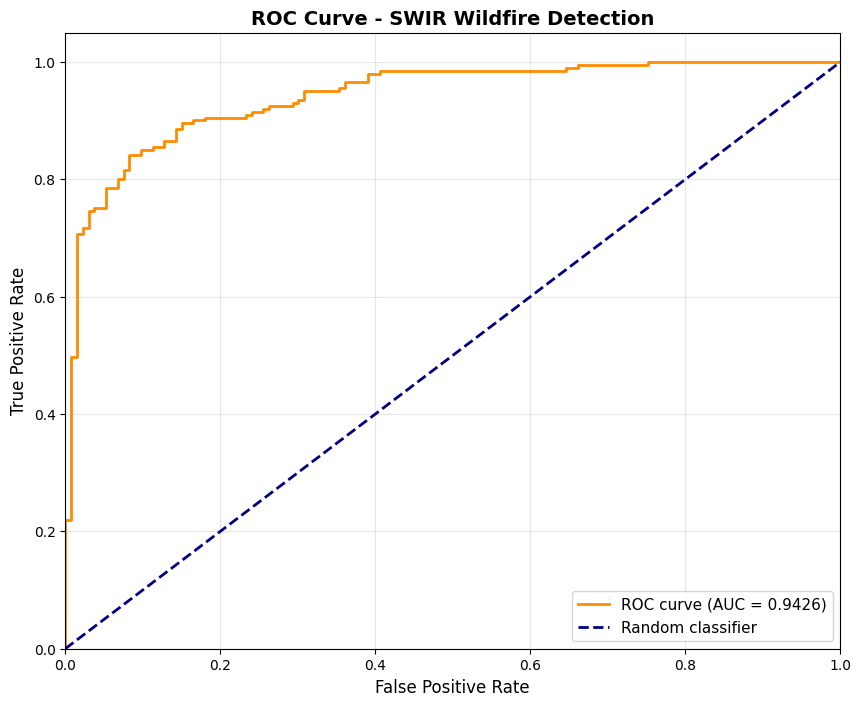

✅ ROC curve saved

📈 Generating Precision-Recall Curve...


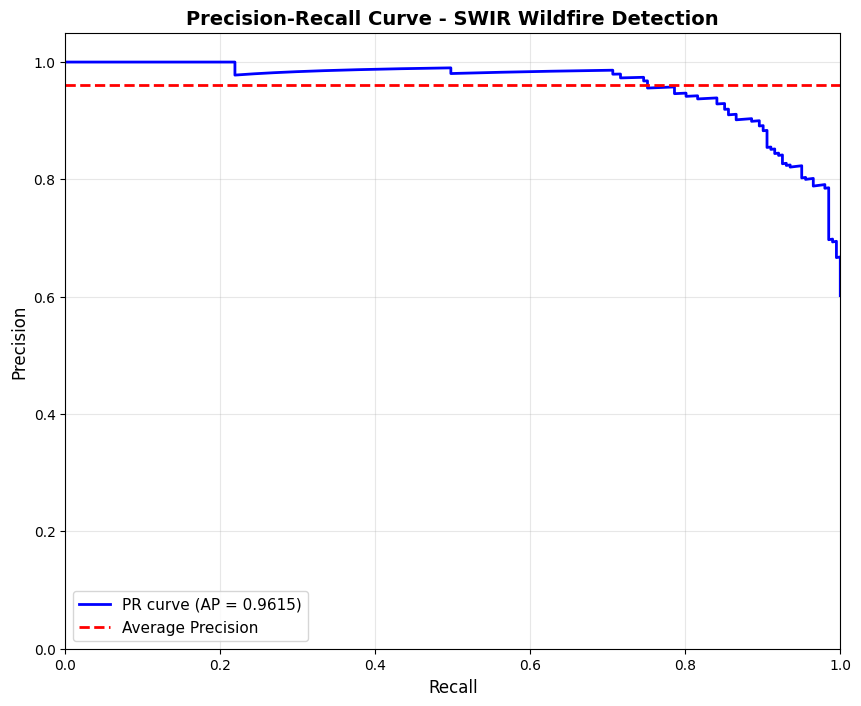

✅ PR curve saved

📈 Generating Confusion Matrix...


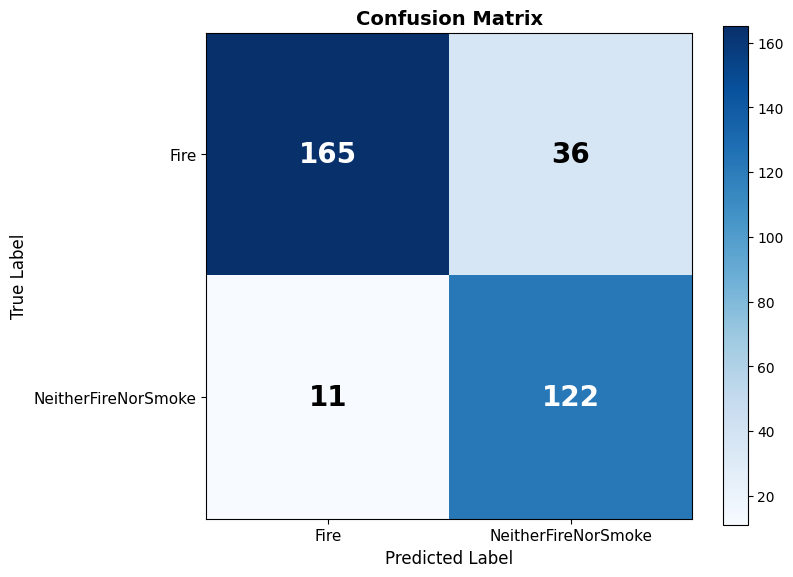

✅ Confusion matrix saved

📈 Generating Metrics Comparison...


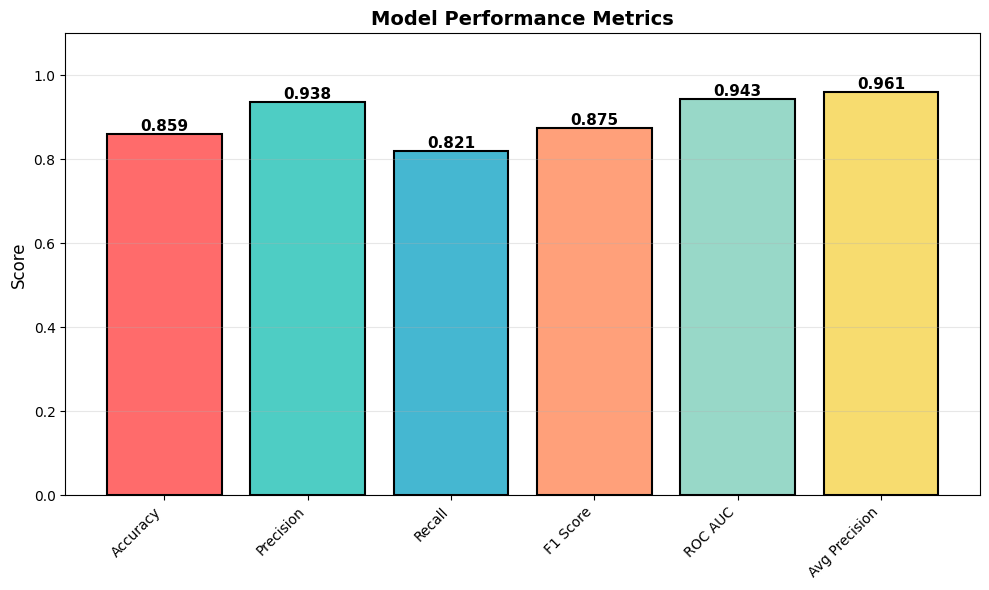

✅ Metrics comparison saved

💾 Backing up to Google Drive...

✅ EVALUATION COMPLETE!

Results saved to:
  • outputs/roc_curve.png
  • outputs/precision_recall_curve.png
  • outputs/confusion_matrix.png
  • outputs/metrics_comparison.png

Backup: MyDrive/Fire neitherfirenorsmoke/evaluation_results/



In [18]:
# ============================================================
# COMPLETE MODEL EVALUATION IN COLAB
# Run this after training or in a fresh session
# ============================================================

print("="*70)
print("🔥 EVALUATING MODEL ON TEST SET")
print("="*70 + "\n")

import torch
import torch.nn as nn
import numpy as np
import yaml
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt
from tqdm import tqdm

# ============================================================
# RECREATE MODEL (if not already in memory)
# ============================================================
print("🔧 Creating model...")

# Load configs
with open('configs/model_config.yaml') as f:
    model_config = yaml.safe_load(f)
with open('configs/training_config.yaml') as f:
    train_config = yaml.safe_load(f)
with open('configs/data_config.yaml') as f:
    data_config = yaml.safe_load(f)

# Import model
import sys
sys.path.append('.')
from src.models.swir_vit import SWIRViT
from src.data.dataset import SWIRWildfireDataset

# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SWIRViT(model_config['model']).to(device)
print(f"✅ Model created on {device}")

# ============================================================
# LOAD BEST CHECKPOINT
# ============================================================
print("\n📥 Loading best model checkpoint...")
checkpoint = torch.load('outputs/checkpoints/best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print(f"✅ Model loaded from Epoch {checkpoint['epoch']}")
print(f"   Training Val Acc: {checkpoint.get('val_acc', 'N/A')}%\n")

# ============================================================
# CREATE TEST DATASET
# ============================================================
print("📁 Loading test dataset...")

from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_dataset = SWIRWildfireDataset(
    data_config['data']['processed_dir'],
    data_config['data']['annotations'],
    transform,
    'test'
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

print(f"✅ Test set loaded: {len(test_dataset)} images\n")

# ============================================================
# EVALUATE ON TEST SET
# ============================================================
print("🔍 Running evaluation...")

all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs[:, 0].cpu().numpy())  # Probability of fire (class 0)

# Convert to numpy
y_true = np.array(all_labels)
y_pred = np.array(all_preds)
y_proba = np.array(all_probs)

# ============================================================
# CALCULATE METRICS
# ============================================================
print("\n📊 Calculating metrics...\n")

# Basic metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, pos_label=0)
recall = recall_score(y_true, y_pred, pos_label=0)
f1 = f1_score(y_true, y_pred, pos_label=0)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# ROC metrics
fpr, tpr, _ = roc_curve(y_true, y_proba, pos_label=0)
roc_auc = auc(fpr, tpr)

# PR metrics
precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_proba, pos_label=0)
avg_precision = average_precision_score(y_true, y_proba, pos_label=0)

# ============================================================
# DISPLAY RESULTS
# ============================================================
print("="*70)
print("📊 EVALUATION RESULTS")
print("="*70)

print(f"\n🎯 Overall Metrics:")
print(f"   Accuracy:  {accuracy*100:.2f}%")
print(f"   Precision: {precision*100:.2f}%")
print(f"   Recall:    {recall*100:.2f}%")
print(f"   F1 Score:  {f1*100:.2f}%")
print(f"   ROC AUC:   {roc_auc:.4f}")
print(f"   Avg Precision: {avg_precision:.4f}")

print(f"\n📋 Confusion Matrix:")
print(f"                      Predicted")
print(f"                Fire        Safe")
print(f"   Actual Fire  {cm[0,0]:4d}        {cm[0,1]:4d}")
print(f"   Actual Safe  {cm[1,0]:4d}        {cm[1,1]:4d}")

# Detailed breakdown
tp, fn = cm[0,0], cm[0,1]
fp, tn = cm[1,0], cm[1,1]
total = tp + tn + fp + fn

print(f"\n🔍 Detailed Metrics:")
print(f"   True Positives (TP):  {tp} (Fire correctly detected)")
print(f"   True Negatives (TN):  {tn} (Safe correctly identified)")
print(f"   False Positives (FP): {fp} (False alarms)")
print(f"   False Negatives (FN): {fn} (Missed fires - CRITICAL!)")

print(f"\n⚠️  Error Analysis:")
print(f"   False Alarm Rate: {fp/total*100:.2f}% ({fp}/{total})")
print(f"   Missed Fire Rate: {fn/total*100:.2f}% ({fn}/{total})")

print("\n" + "="*70)

# ============================================================
# CLASSIFICATION REPORT
# ============================================================
print("\n📄 Detailed Classification Report:\n")
classes = ['Fire', 'NeitherFireNorSmoke']
print(classification_report(y_true, y_pred, target_names=classes))

# ============================================================
# PLOT ROC CURVE
# ============================================================
print("\n📈 Generating ROC Curve...")
plt.figure(figsize=(10, 8))

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - SWIR Wildfire Detection', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.savefig('outputs/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ ROC curve saved")

# ============================================================
# PLOT PRECISION-RECALL CURVE
# ============================================================
print("\n📈 Generating Precision-Recall Curve...")
plt.figure(figsize=(10, 8))

plt.plot(recall_curve, precision_curve, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.4f})')
plt.axhline(y=avg_precision, color='red', linestyle='--', lw=2, label=f'Average Precision')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve - SWIR Wildfire Detection', fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=11)
plt.grid(alpha=0.3)
plt.savefig('outputs/precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ PR curve saved")

# ============================================================
# PLOT CONFUSION MATRIX
# ============================================================
print("\n📈 Generating Confusion Matrix...")
plt.figure(figsize=(8, 6))

plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.colorbar()

tick_marks = np.arange(2)
plt.xticks(tick_marks, classes, fontsize=11)
plt.yticks(tick_marks, classes, fontsize=11)

thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=20, fontweight='bold')

plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('outputs/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Confusion matrix saved")

# ============================================================
# PLOT METRICS COMPARISON
# ============================================================
print("\n📈 Generating Metrics Comparison...")
plt.figure(figsize=(10, 6))

metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'Avg Precision']
metrics_values = [accuracy, precision, recall, f1, roc_auc, avg_precision]

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']
bars = plt.bar(metrics_names, metrics_values, color=colors, edgecolor='black', linewidth=1.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.ylim([0, 1.1])
plt.ylabel('Score', fontsize=12)
plt.title('Model Performance Metrics', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Metrics comparison saved")

# ============================================================
# BACKUP TO DRIVE
# ============================================================
print("\n💾 Backing up to Google Drive...")
!mkdir -p "/content/drive/MyDrive/Fire neitherfirenorsmoke/evaluation_results"
!cp outputs/*.png "/content/drive/MyDrive/Fire neitherfirenorsmoke/evaluation_results/"

print("\n" + "="*70)
print("✅ EVALUATION COMPLETE!")
print("="*70)
print("\nResults saved to:")
print("  • outputs/roc_curve.png")
print("  • outputs/precision_recall_curve.png")
print("  • outputs/confusion_matrix.png")
print("  • outputs/metrics_comparison.png")
print("\nBackup: MyDrive/Fire neitherfirenorsmoke/evaluation_results/")
print("="*70 + "\n")
